In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-histopathology-images' dataset.
Path to dataset files: /kaggle/input/breast-histopathology-images


✅ Loaded 6400 training and 1600 test images.

Training with OscillatingLR
OscillatingLR | Epoch [1/20] | Loss: 0.4617 | Acc: 79.30%
OscillatingLR | Epoch [2/20] | Loss: 0.4055 | Acc: 82.50%
OscillatingLR | Epoch [3/20] | Loss: 0.3839 | Acc: 83.62%
OscillatingLR | Epoch [4/20] | Loss: 0.3755 | Acc: 84.08%
OscillatingLR | Epoch [5/20] | Loss: 0.3667 | Acc: 83.73%
OscillatingLR | Epoch [6/20] | Loss: 0.3591 | Acc: 84.33%
OscillatingLR | Epoch [7/20] | Loss: 0.3495 | Acc: 85.11%
OscillatingLR | Epoch [8/20] | Loss: 0.3408 | Acc: 85.47%
OscillatingLR | Epoch [9/20] | Loss: 0.3334 | Acc: 85.47%
OscillatingLR | Epoch [10/20] | Loss: 0.3357 | Acc: 85.42%

Training with SGD
SGD | Epoch [1/20] | Loss: 0.4860 | Acc: 77.34%
SGD | Epoch [2/20] | Loss: 0.4315 | Acc: 81.53%
SGD | Epoch [3/20] | Loss: 0.3888 | Acc: 82.94%
SGD | Epoch [4/20] | Loss: 0.3790 | Acc: 83.66%
SGD | Epoch [5/20] | Loss: 0.3613 | Acc: 84.30%
SGD | Epoch [6/20] | Loss: 0.3593 | Acc: 84.64%
SGD | Epoch [7/20] | Loss: 0.3512 | Ac

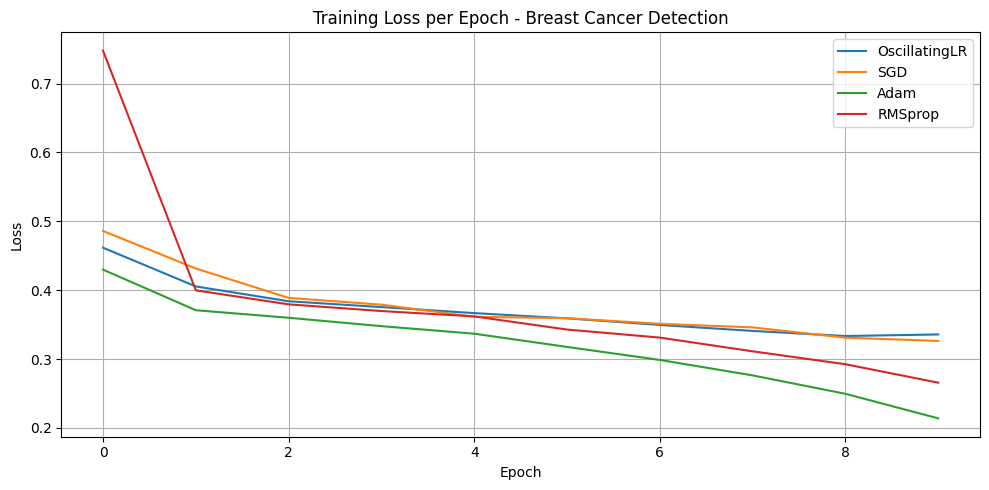

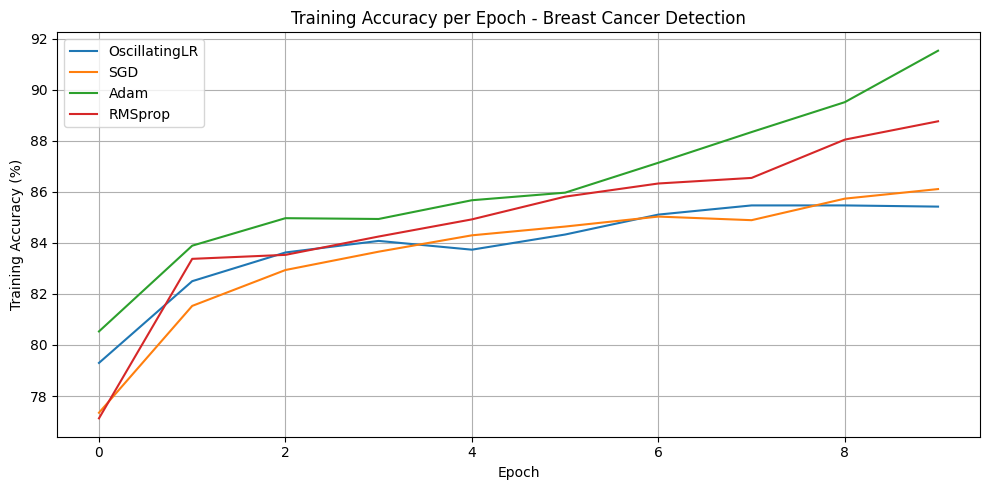


✅ Final Test Accuracy:
OscillatingLR: 84.94%
SGD: 84.75%
Adam: 83.94%
RMSprop: 84.44%


In [2]:
# ============================================================
# Breast Cancer Detection (Histopathology Images)
# Comparison: OscillatingLR vs SGD vs Adam vs RMSprop
# ============================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# ----------------------------
# 1. Reproducibility
# ----------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ----------------------------
# 2. Custom OscillatingLR Optimizer
# ----------------------------
class OscillatingLR(optim.Optimizer):
    def __init__(self, params, base_lr=0.01, oscillation_factor=0.005, momentum=0.9, decay=0.0005):
        self.base_lr = base_lr
        self.oscillation_factor = oscillation_factor
        self.momentum = momentum
        self.decay = decay
        self.step_count = 0
        defaults = dict(momentum=momentum)
        super(OscillatingLR, self).__init__(params, defaults)
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param)}

    def step(self, closure=None):
        self.step_count += 1
        decay_factor = 1.0 / (1.0 + self.decay * self.step_count)
        if self.step_count % 2 == 0:
            lr = self.base_lr + self.oscillation_factor * decay_factor
        else:
            lr = self.base_lr - self.oscillation_factor * decay_factor

        for group in self.param_groups:
            momentum = group['momentum']
            for param in group['params']:
                if param.grad is not None:
                    velocity = self.state[param]['velocity']
                    velocity.mul_(momentum).add_(param.grad)
                    param.data -= lr * velocity
                    self.state[param]['velocity'] = velocity

        return lr

# ----------------------------
# 3. Data loading from your Kaggle path
# ----------------------------
data_dir = "/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/"

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Define the classes of interest (assuming '0' is benign and '1' is malignant based on common practice)
# You might need to inspect the dataset structure to confirm these labels.
classes_of_interest = ['0', '1']
class_to_idx = {cls: i for i, cls in enumerate(classes_of_interest)}
idx_to_class = {i: cls for i, cls in enumerate(classes_of_interest)}

# Filter the dataset to include only images from the classes of interest
filtered_samples = [(path, class_to_idx[os.path.basename(os.path.dirname(path))])
                    for path, label in full_dataset.samples
                    if os.path.basename(os.path.dirname(path)) in classes_of_interest]

full_dataset.samples = filtered_samples
full_dataset.targets = [s[1] for s in filtered_samples]


# Optionally limit to smaller subset for faster training
subset_size = 8000
if len(full_dataset) > subset_size:
    dataset = torch.utils.data.Subset(full_dataset, np.random.choice(len(full_dataset), subset_size, replace=False))
else:
    dataset = full_dataset


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"✅ Loaded {len(train_dataset)} training and {len(test_dataset)} test images.")

# ----------------------------
# 4. CNN model
# ----------------------------
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ----------------------------
# 5. Training and evaluation
# ----------------------------
def train_and_evaluate(optimizer_name, optimizer_class, **opt_params):
    model = CancerCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), **opt_params)
    num_epochs = 20  # increase to 10–20 for better accuracy
    epoch_losses, epoch_accs = [], []

    for epoch in range(10):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        epoch_losses.append(avg_loss)
        epoch_accs.append(accuracy)
        print(f"{optimizer_name} | Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Acc: {accuracy:.2f}%")

    # Evaluate on test set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    return epoch_losses, epoch_accs, test_acc

# ----------------------------
# 6. Run comparisons
# ----------------------------
optimizers = {
    "OscillatingLR": (OscillatingLR, {"base_lr": 0.01, "oscillation_factor": 0.005, "momentum": 0.9}),
    "SGD": (optim.SGD, {"lr": 0.01, "momentum": 0.9}),
    "Adam": (optim.Adam, {"lr": 0.001}),
    "RMSprop": (optim.RMSprop, {"lr": 0.001}),
}

results = {}
for name, (opt_class, opt_params) in optimizers.items():
    print("\n" + "="*70)
    print(f"Training with {name}")
    losses, accs, test_acc = train_and_evaluate(name, opt_class, **opt_params)
    results[name] = {"losses": losses, "accs": accs, "test_acc": test_acc}

# ----------------------------
# 7. Visualization
# ----------------------------
plt.figure(figsize=(10,5))
for name in results:
    plt.plot(results[name]["losses"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch - Breast Cancer Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cancer_loss_comparison.png")
plt.show()

plt.figure(figsize=(10,5))
for name in results:
    plt.plot(results[name]["accs"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy (%)")
plt.title("Training Accuracy per Epoch - Breast Cancer Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cancer_accuracy_comparison.png")
plt.show()

print("\n✅ Final Test Accuracy:")
for name in results:
    print(f"{name}: {results[name]['test_acc']:.2f}%")

In [ ]:
pip freeze

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.11.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.1
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.0
altair==5.5.0
annotated-doc==0.0.3
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.2
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.10.27.0.39.10
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.4
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.27.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.11.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==